In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

Reading the text file and sperating the corresponding tokens and tags

In [2]:
def read_data(file_path):
    tokens = []
    tags = []

    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token


            if(token.startswith('@')):
                token = '<USR>'
            elif(token.startswith('http://') or token.startswith('https://')):
                token = '<URL>'
            tweet_tokens.append(token)
            tweet_tags.append(tag)

    return tokens, tags


In [4]:
tokens,tags = read_data('NER-Dataset-Train.txt')


Combing each individual words with their tags into to form each sentences

In [5]:
sentences = [list(zip(sub_tokens, sub_tags)) for sub_tokens, sub_tags in zip(tokens, tags)]
print(sentences[0])

[('<USR>', 'O'), ('Trust', 'O'), ('me', 'O'), ('!', 'O'), ('im', 'O'), ('gonna', 'O'), ('be', 'O'), ('bringing', 'O'), ('out', 'O'), ('music', 'O'), ('like', 'O'), ('theres', 'O'), ('no', 'O'), ('tomorrow', 'O'), (',', 'O'), ('Be', 'O'), ('doing', 'O'), ('pure', 'O'), ('blog', 'O'), ('videos', 'O'), ('&amp;', 'O'), ('freestyle', 'O'), ('videos', 'O'), ('#Moesh', 'O'), ('!', 'O')]


Printing the number of Words , Sentences and Unique words and Unique Tags

Number of Sentences: 900
Maximum sequence length: 37
Number of unique words: 4599


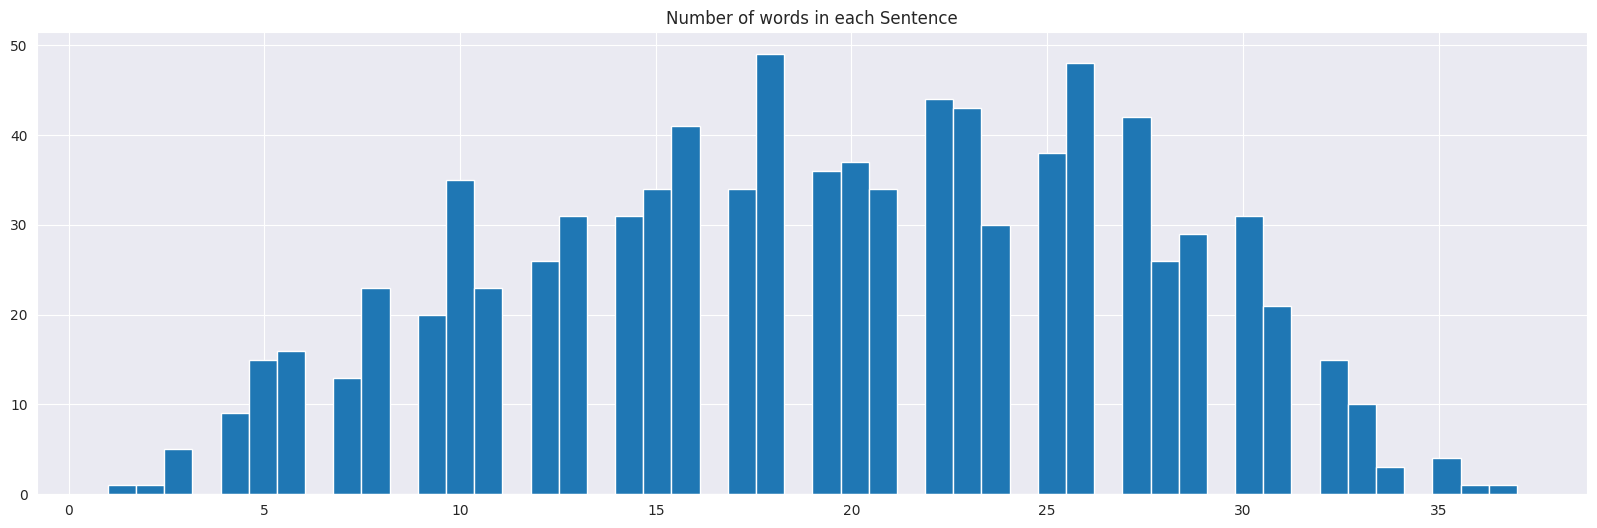

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist([len(s) for s in sentences], bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = max([len(s) for s in sentences])
print('Number of Sentences:', len(sentences))
print ('Maximum sequence length:', maxlen)

flattened_tokens = [item for sublist in tokens for item in sublist]

# Create a set of unique words
words = list(set(flattened_tokens))
words.append("ENDPAD")
n_words = len(words)
print('Number of unique words:', n_words)

/tmp/ipykernel_47998/282591290.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(unique_tags, rotation=45)


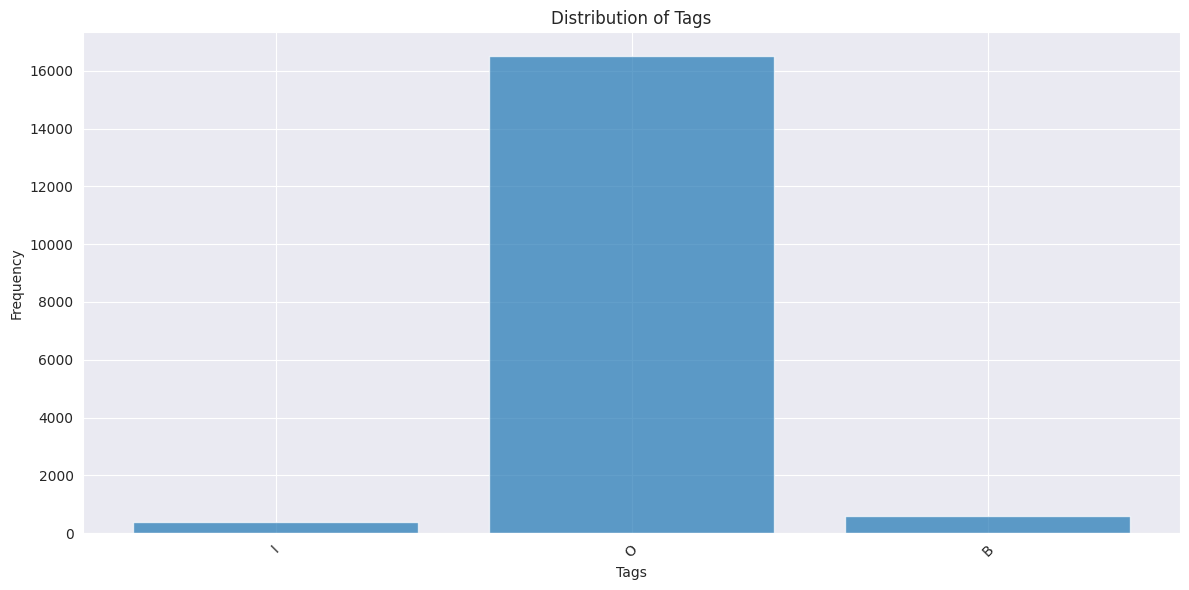

Number of unique Tags: 3


In [7]:
# Flatten the list of lists
flattened_tags = [item for sublist in tags for item in sublist]

# Create a set of unique tags
unique_tags = list(set(flattened_tags))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Distribution of Tags
ax.bar(unique_tags, [flattened_tags.count(tag) for tag in unique_tags], alpha=0.7)
ax.set_xticklabels(unique_tags, rotation=45)
ax.set_title('Distribution of Tags')
ax.set_xlabel('Tags')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Number of unique tags
n_tags = len(unique_tags)
print('Number of unique Tags:', n_tags)

Getiing the word to index and tag to index

In [8]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(unique_tags)}

Preprocessing the data into feature x and lable y

In [9]:
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [10]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = sequence.pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

print('X shape', X.shape, 'y shape', y.shape)

X shape (900, 37) y shape (900, 37, 3)


Model Configuration/Hyperparameters

In [11]:
class config():
    VOCAB = n_words
    MAX_LEN = maxlen
    N_OUPUT = n_tags


    EMBEDDING_VECTOR_LENGTH = 50
    N_LSTM_CELLS = 64
    RECURRENT_DROPOUT = 0.1

    OUTPUT_ACTIVATION = 'softmax'

    LOSS = 'categorical_crossentropy'
    OPTIMIZER = 'adam'
    METRICS = ['accuracy']

    MAX_EPOCHS = 15

RNN Model

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model = Sequential()
model.add(
    Embedding(
        input_dim=config.VOCAB, output_dim=config.EMBEDDING_VECTOR_LENGTH, input_length=config.MAX_LEN
    )
)
model.add(
    Bidirectional(
        LSTM(config.N_LSTM_CELLS, return_sequences=True, recurrent_dropout=config.RECURRENT_DROPOUT)
    )
)
model.add(
    TimeDistributed(
        Dense(config.N_OUPUT, activation=config.OUTPUT_ACTIVATION)
    )
)
model.compile(loss=config.LOSS, optimizer=config.OPTIMIZER, metrics=config.METRICS)

model.summary()
plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 37, 50)            229950    
                                                                 
 bidirectional_1 (Bidirecti  (None, 37, 128)           58880     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 37, 3)             387       
 stributed)                                                      
                                                                 
Total params: 289217 (1.10 MB)
Trainable params: 289217 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Training and testing

In [13]:
history = model.fit(x=X, y=y, validation_split=0.2,
    callbacks=[es,  rlp], epochs=config.MAX_EPOCHS
)


Epoch 1/15
23/23 [==============================] - 30s 395ms/step - loss: 0.6414 - accuracy: 0.9571 - val_loss: 0.1521 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - 11s 484ms/step - loss: 0.1660 - accuracy: 0.9701 - val_loss: 0.1276 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - 14s 585ms/step - loss: 0.1397 - accuracy: 0.9701 - val_loss: 0.1220 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - 7s 311ms/step - loss: 0.1287 - accuracy: 0.9701 - val_loss: 0.1187 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/15
23/23 [==============================] - 8s 357ms/step - loss: 0.1194 - accuracy: 0.9701 - val_loss: 0.1163 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/15
23/23 [==============================] - 7s 318ms/step - loss: 0.1101 - accuracy: 0.9701 - val_loss: 0.1147 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/15
23/23 [==============================] - 7s 296ms/step -

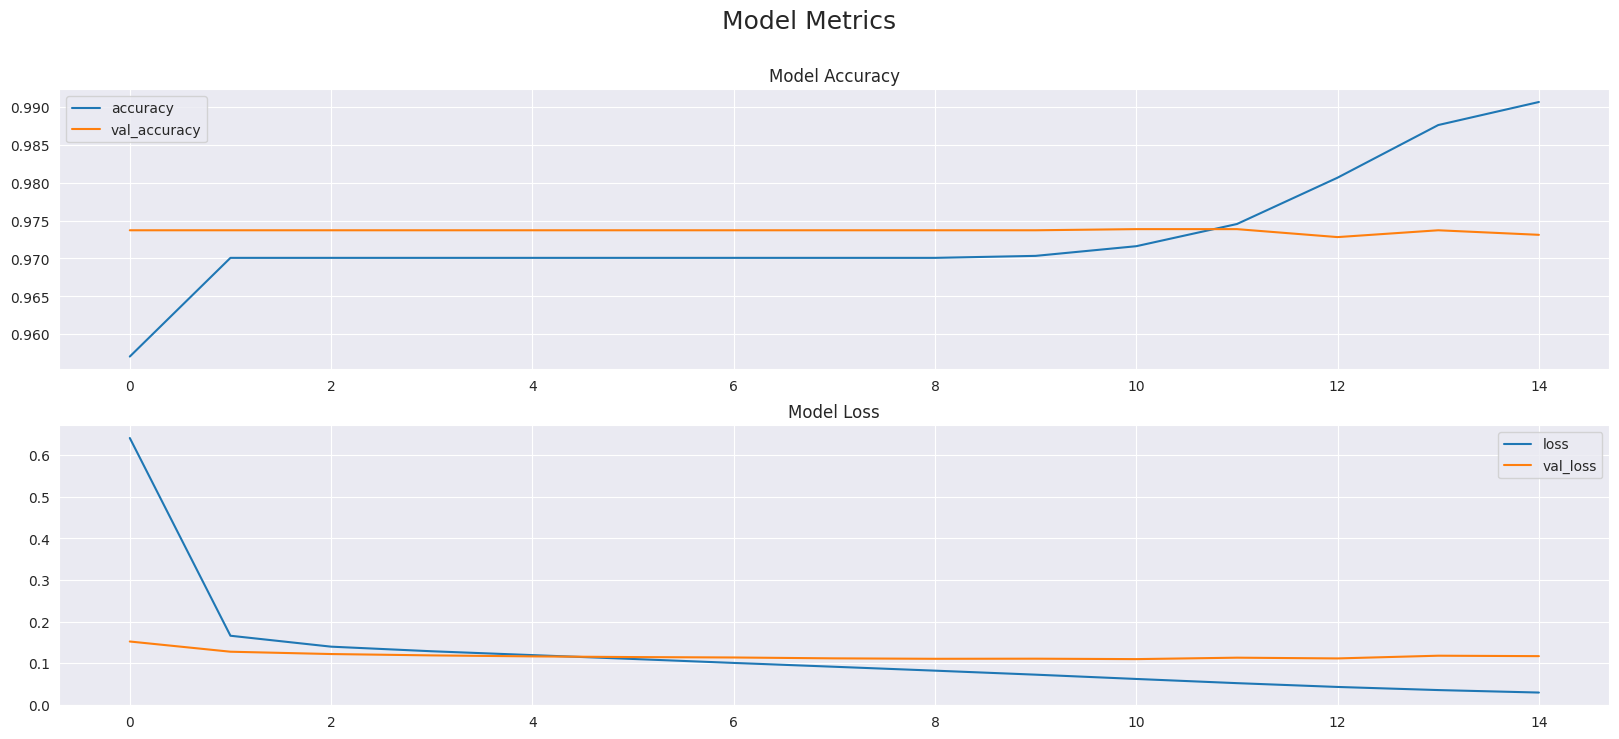

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);



In [15]:
import tensorflow as tf
# Step 1: Make Predictions
predictions = model.predict(X)

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=2).numpy()
true_labels = tf.argmax(y, axis=2).numpy()

# Step 2: Compute Metrics
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_labels, true_labels), dtype=tf.float32)).numpy()

# Calculate true positives, false positives, and false negatives for each class
true_positives = tf.math.count_nonzero(predicted_labels * true_labels, axis=0).numpy()
false_positives = tf.math.count_nonzero(predicted_labels * (1 - true_labels), axis=0).numpy()
false_negatives = tf.math.count_nonzero((1 - predicted_labels) * true_labels, axis=0).numpy()

# Calculate precision, recall, and F1 score for each class
precision = true_positives / (true_positives + false_positives + 1e-7)
recall = true_positives / (true_positives + false_negatives + 1e-7)
f1 = 2 * precision * recall / (precision + recall + 1e-7)

# Compute average precision, recall, and F1 score across all classes
average_precision = tf.reduce_mean(precision).numpy()
average_recall = tf.reduce_mean(recall).numpy()
average_f1 = tf.reduce_mean(f1).numpy()

print("Accuracy:", accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)

 5/29 [====>.........................] - ETA: 1s

29/29 [==============================] - 3s 59ms/step
Accuracy: 0.98834836
Average Precision: 0.9787249437112495
Average Recall: 0.985234299837674
Average F1 Score: 0.981957136691391
